# Практика: Bagging + Random Forest

In [24]:
import tqdm
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from base import DecisionTree

## 1. Bagging над деревьями решений

Реализуем алгоритм бэггинга, в качестве базовых моделей возьмем деревья решений (упрощенная реализация, см. base.py).

In [25]:
class BaggingClassifier(object):
    
    def __init__(self, base_model_class, n_base_models, **base_model_params):
        """
        Initialize instance of BaggingClassifier (build base models)
        :param base_model_class: class (not instance!) of a model to be used as base model
        :param n_base_models: int number of base models to use in bagging
        :param **base_model_params: **kwargs of params to pass to base_models .init() method
        """
        self.n_base_models = n_base_models
        self.base_models = [self._create_model_(base_model_class, **base_model_params) 
                            for _ in range(self.n_base_models)]
    
    def _create_model_(self, base_model_class, **base_model_params):
        return base_model_class(**base_model_params)
    
    def _create_bagging_subsample_(self, X, y):
        """
        Create subsample of X using bagging sampling
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets
        :return X_bagging: array-like features of subsample 
        :return y_bagging: array-like targets of subsample
        """
        X_bagging, y_bagging = None, None
        #TODO: your code here
        idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_bagging = X[idx]
        y_bagging = y[idx]
        return X_bagging, y_bagging
        
    def train(self, X, y):
        """
        Train classifier by calling .train() method of base models
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets
        """
        for base_model in self.base_models:
            X_bagging, y_bagging = self._create_bagging_subsample_(X, y)
            base_model.train(X_bagging, y_bagging)
    
    def predict(self, X):
        """
        Make prediction for X using .predict() method of base models and simple voting
        :param X: array-like features (n_obj x n_features)
        :return results: array-like target predictions (n_obj)
        """
        # N_objects x N_base_models
        base_models_predictions = np.asarray([base_model.predict(X) for base_model in self.base_models], dtype=np.int).transpose(1, 0)  
        result = None
        #TODO: your code here - handle base model format
        uniques, counts = np.unique(base_models_predictions, return_counts=True)
        result = uniques[np.argmax(counts)]
        return np.asarray(result)
    
    def predict_proba(self, X):
        """
        Make probability prediction for X using .predict_proba() method of base models and averaging them
        :param X: array-like features (n_obj x n_features)
        :return results: array-like target probabilities predictions (n_obj x n_classes)
        """
        # N_objects xы N_base_models x N_classes
        base_models_predictions = np.asarray([base_model.predict_proba(X) 
                                              for base_model in self.base_models], dtype=np.float).transpose(1, 0, 2)  
        return base_models_predictions.mean(axis=1)

Вспомогательные функции:

In [26]:
def calc_accuracy(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = (y_true == y_pred).mean()
    return accuracy

In [27]:
def plot_accuracies(param_name, param_values, train_accuracies, val_accuracies, log_x=False):
    plt.figure(figsize=(16, 8))
    plt.plot(param_values, train_accuracies, 'o-', label='train')
    plt.plot(param_values, val_accuracies, 'o-', label='val')

    plt.xlabel(param_name)
    if log_x:
        plt.xscale('log')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.title(param_name)
    plt.show()

In [28]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

def plot_model(X, y, clf, proba=False, title=''):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(16, 8))    
    plt.title(title)
    plt.pcolormesh(xx, yy, predicted, alpha=0.7, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolors='b', linewidths=1, cmap='spring')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.show()

### 1.1. Разбиение признакового пространства бэггингом
Повторим эксперимент с разбиением признакового пространства игрушечного датасета с прошлого занятия, но в этот раз в качестве алгоритма используем бэггинг.

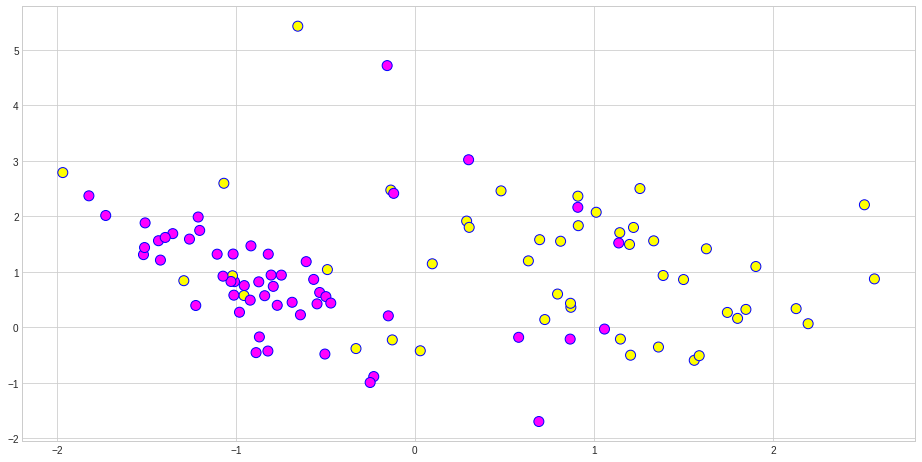

In [29]:
from sklearn.datasets import make_classification

X_toy, y_toy = make_classification(n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
plt.figure(figsize=(16, 8))
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, edgecolors='b', linewidths=1, s=100, cmap='spring')
plt.show()

Будем последовательно увеличивать число базовых алгоритмов для бэггинга и смотреть на то, как он разбивает пространство признаков:

n_base_models: 1, accuracy: 0.540


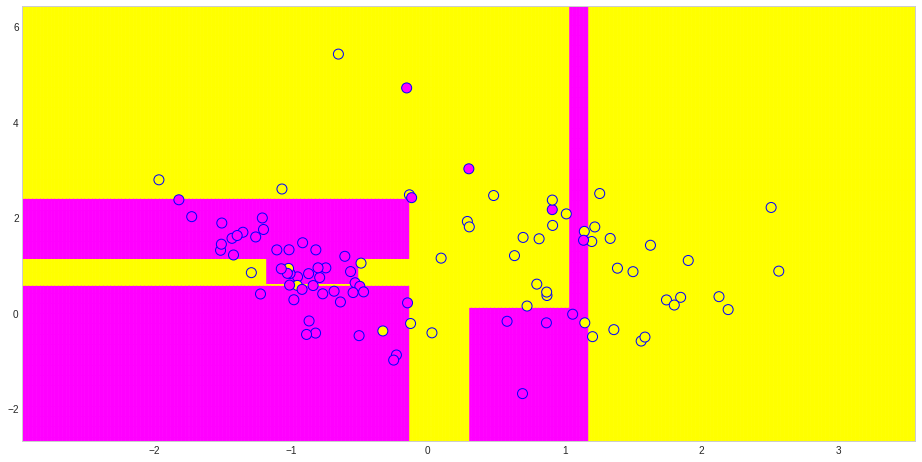

n_base_models: 2, accuracy: 0.540


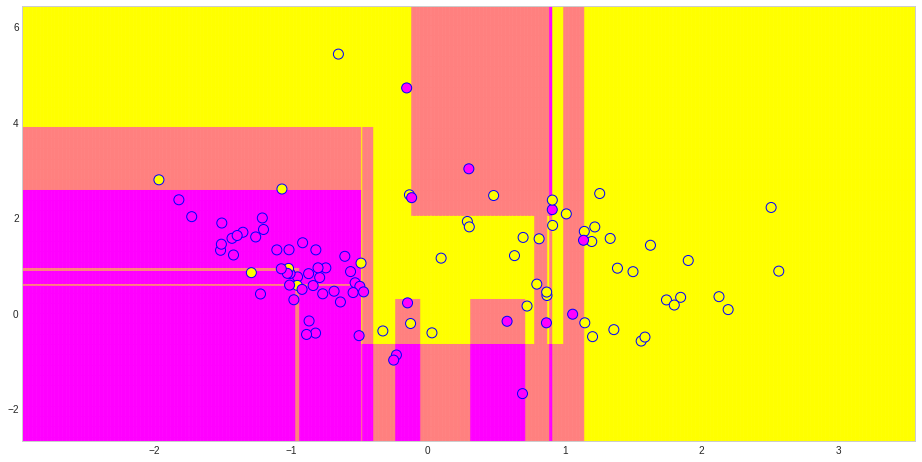

n_base_models: 5, accuracy: 0.540


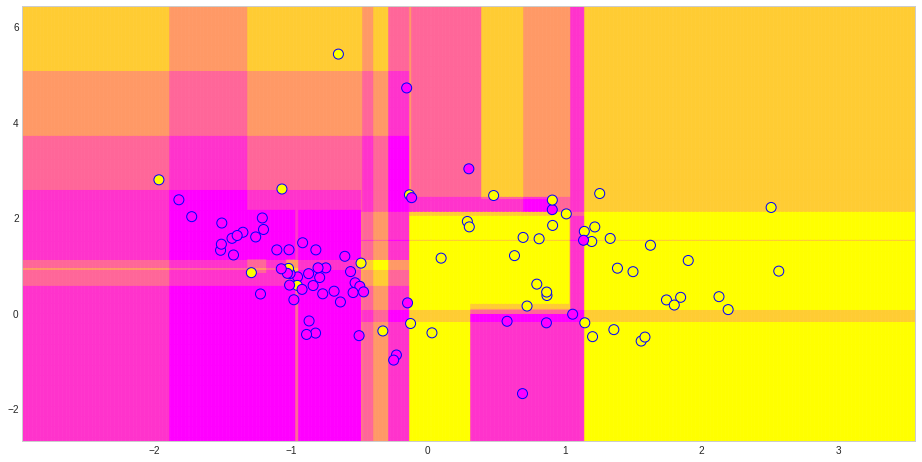

In [30]:
for n_base_models in (1, 2, 5):#, 10, 25, 50):
    bagger = BaggingClassifier(base_model_class=DecisionTree, n_base_models=n_base_models)
    bagger.train(X_toy, y_toy)
    
    y_pred = bagger.predict(X_toy)
    accuracy = (y_toy == y_pred).mean()
    print('n_base_models: {}, accuracy: {:.3f}'.format(n_base_models, accuracy))
    
    plot_model(X_toy, y_toy, bagger, proba=True)

Как мы видим, границы между многими смежными областями "размазываются", это значит, что в этих областях отдельные базовые модели  "не соглашаются" друг с другом.

## 2. Random Forest

Теперь перейдем непосредственно к алгоритму случайного леса. Его построить очень легко - у нас уже написан класс для бэггинга, а случайный лес отличается от него только тем, что каждое дерево рассматривает свое подмножество признаков для построения

Реализуем эту логику

In [31]:
#TODO: custom subspace sampling in base.py
#then save & reload
import importlib
import base
importlib.reload(base)
from base import DecisionTree

In [32]:
class RandomForestClassifier(BaggingClassifier):
    
    def __init__(self, base_model_class, n_base_models, n_features=None, **base_model_params):
        self.n_base_models = n_base_models
        self.n_features = n_features
        self.base_models = [self._create_model_(base_model_class, **base_model_params) 
                            for _ in range(self.n_base_models)] 
    
    def train(self, X, y):
        """
        Train classifier by calling .train() method of base models
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets
        """
        if self.n_features is None:
            n_features = int(np.sqrt(X.shape[1]))
        else:
            n_features = self.n_features
            
        for base_model in self.base_models:
            X_bagging, y_bagging = self._create_bagging_subsample_(X, y)
            base_model.train(X_bagging, y_bagging, max_features=n_features)

### 2.1. Реальные данные (спам!)

Загрузим данные `Spambase` (задача классификации писем спам/не спам) (http://archive.ics.uci.edu/ml/datasets/Spambase):

*Датасет `Titanic` нам мало подходит - в нем всего лишь 7 признаков, и было бы странно уменьшать это число для каждого дерева*

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts

data = pd.read_csv('ensembles_1_data.csv', header=None)
print(data.shape)
data.head()

(4601, 58)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
X = data.values[:, :-1]
y = data.values[:, -1].astype(int)
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, random_state=123)
print(X.shape, y.shape)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(4601, 57) (4601,)
(3680, 57) (921, 57)
(3680,) (921,)


Проверим, как будет вести себя ошибка на валидации при увеличении числа деревьев в ансамбле.
Число признаков возьмем так, рекомендуют для задачи классификации (корень из общего числа признаков):

**NB:** это займет некоторое время!

 33%|███▎      | 1/3 [00:02<00:05,  2.93s/it]

Accuracy: 0.9652173913043478 0.9001085776330076


 67%|██████▋   | 2/3 [00:09<00:03,  4.00s/it]

Accuracy: 0.9538043478260869 0.9185667752442996


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]

Accuracy: 0.9904891304347826 0.9478827361563518


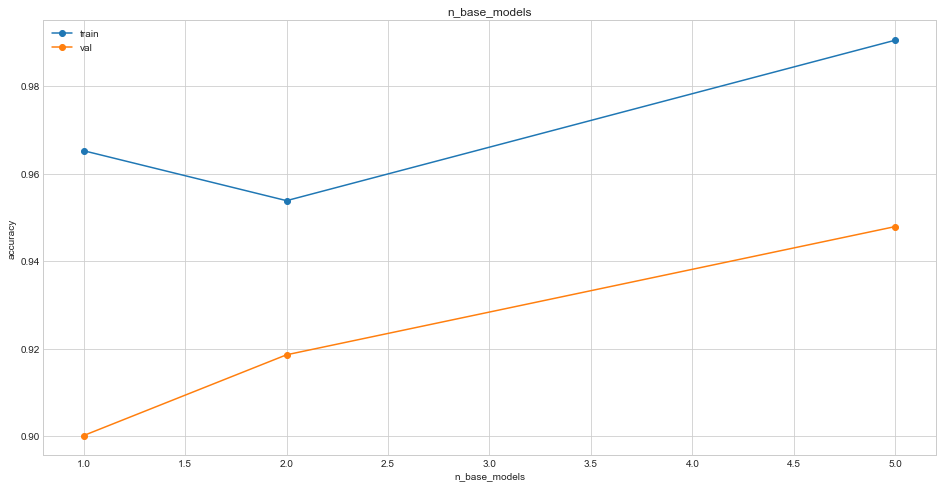

In [ ]:
n_base_models_range = (1, 2, 5, 10)#, 15, 25, 50)
train_accuracies = []
val_accuracies = []
n_features = int(np.sqrt(X_train.shape[1]))
for n_base_models in tqdm.tqdm(n_base_models_range):
    forest = RandomForestClassifier(base_model_class=DecisionTree, n_base_models=n_base_models, n_features=n_features)
    forest.train(X_train, y_train)
    train_accuracies.append(calc_accuracy(forest, X_train, y_train))
    val_accuracies.append(calc_accuracy(forest, X_val, y_val))
    print('Accuracy:',train_accuracies[-1], val_accuracies[-1])
plot_accuracies('n_base_models', n_base_models_range, train_accuracies, val_accuracies)

### 2.2. Важность признаков

Реализовать оценку важности признаков вам предлагается факультативно, посмотрим, как она работает в реализации случайного дерева в `sklearn`.
Импортируем их реализацию и для начала повторим эксперимент выше:

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierSklearn

100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


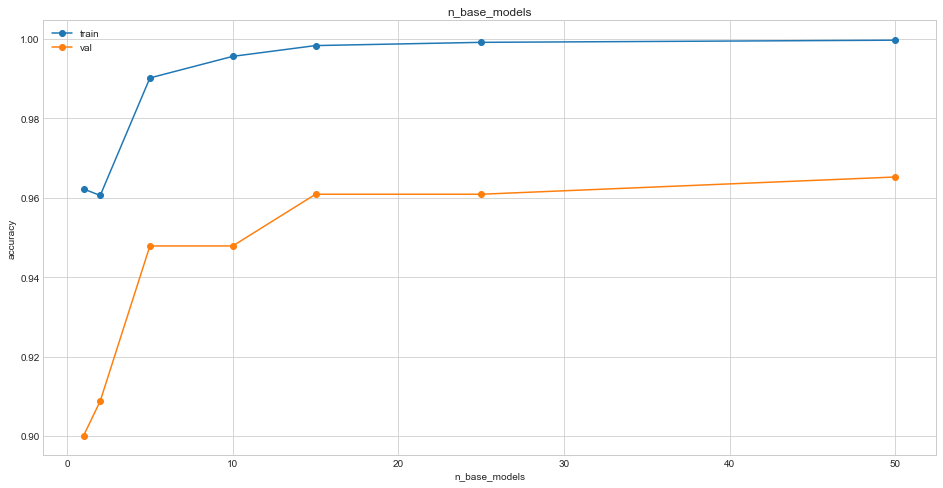

Best val accuracy: 0.9652551574375678 (at 50)


In [ ]:
n_base_models_range = (1, 2, 5, 10, 15, 25, 50)
train_accuracies = []
val_accuracies = []
n_features = int(np.sqrt(X_train.shape[1]))
for n_base_models in tqdm.tqdm(n_base_models_range):
    forest = RandomForestClassifierSklearn(n_estimators=n_base_models)
    forest.fit(X_train, y_train)
    train_accuracies.append(calc_accuracy(forest, X_train, y_train))
    val_accuracies.append(calc_accuracy(forest, X_val, y_val))
plot_accuracies('n_base_models', n_base_models_range, train_accuracies, val_accuracies)
best_idx = np.argmax(val_accuracies)
best_val_accuracy = val_accuracies[best_idx]
print('Best val accuracy: {} (at {})'.format(best_val_accuracy, n_base_models_range[best_idx]))

Теперь посмотрим, какую важность присвоил всем признакам построенный случайный лес:

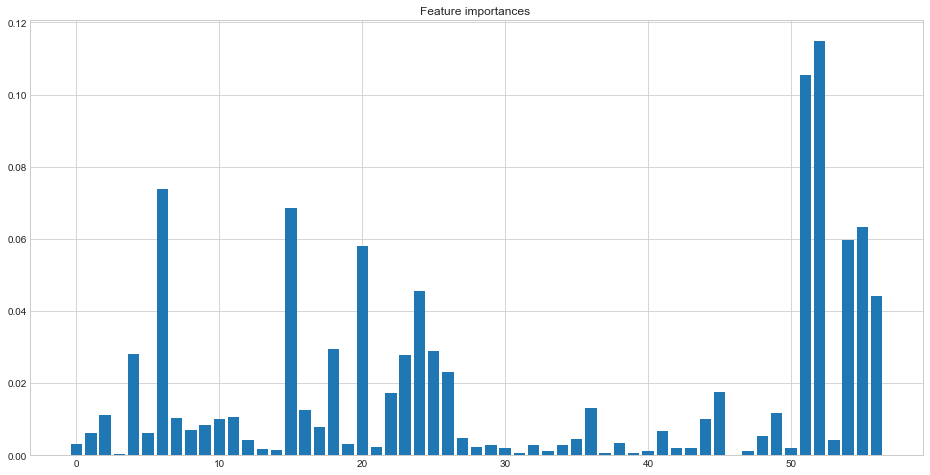

In [ ]:
importances = forest.feature_importances_
plt.figure(figsize=(16, 8))
plt.bar(range(len(importances)), importances)
plt.title('Feature importances ')
plt.show()

Посмотрим, как изменится качество, если мы занулим признаки, важность которых согласно построенному ансамблю меньше 0.01:

In [ ]:
bad_features_idxs = importances < 0.005
print('Number of weak features:', sum(bad_features_idxs))

Number of weak features: 26


In [ ]:
X_train_red = X_train.copy()
X_train_red[:, bad_features_idxs] = 0

100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


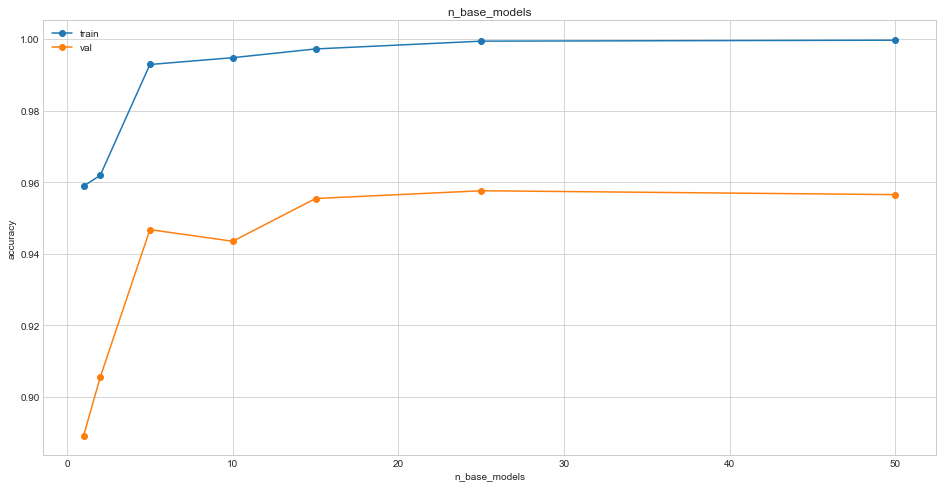

Best val accuracy: 0.9576547231270358 (at 25)


In [ ]:
n_base_models_range = (1, 2, 5, 10, 15, 25, 50)
train_accuracies = []
val_accuracies = []
n_features = int(np.sqrt(X_train.shape[1]))
for n_base_models in tqdm.tqdm(n_base_models_range):
    forest = RandomForestClassifierSklearn(n_estimators=n_base_models)
    forest.fit(X_train_red, y_train)
    train_accuracies.append(calc_accuracy(forest, X_train_red, y_train))
    val_accuracies.append(calc_accuracy(forest, X_val, y_val))
plot_accuracies('n_base_models', n_base_models_range, train_accuracies, val_accuracies)
best_idx = np.argmax(val_accuracies)
best_val_accuracy = val_accuracies[best_idx]
print('Best val accuracy: {} (at {})'.format(best_val_accuracy, n_base_models_range[best_idx]))

Напоследок сравним картины разбиения признакового пространства решающим деревом, бэггингом из 10 деревьев и случайным лесом из 10 деревьев:

In [ ]:
tree = DecisionTree()
bagging = BaggingClassifier(DecisionTree, 10)
forest = RandomForestClassifier(DecisionTree, 10)

In [ ]:
tree.train(X_toy, y_toy)
bagging.train(X_toy, y_toy)
forest.train(X_toy, y_toy)

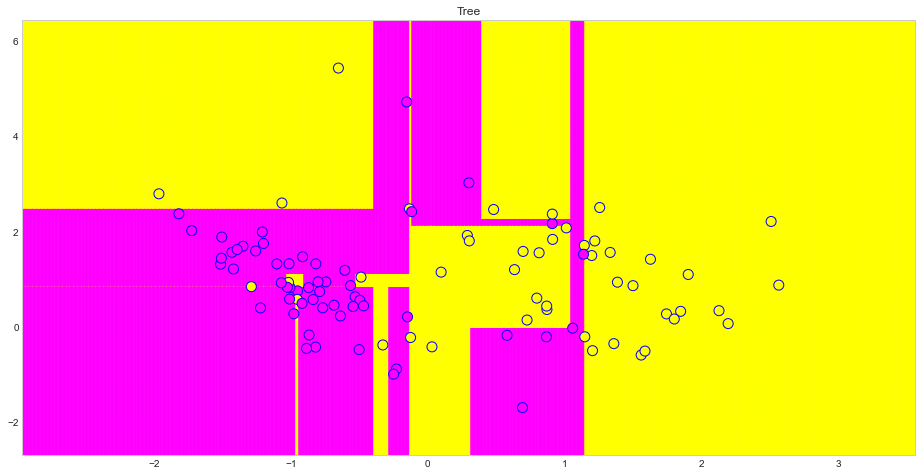

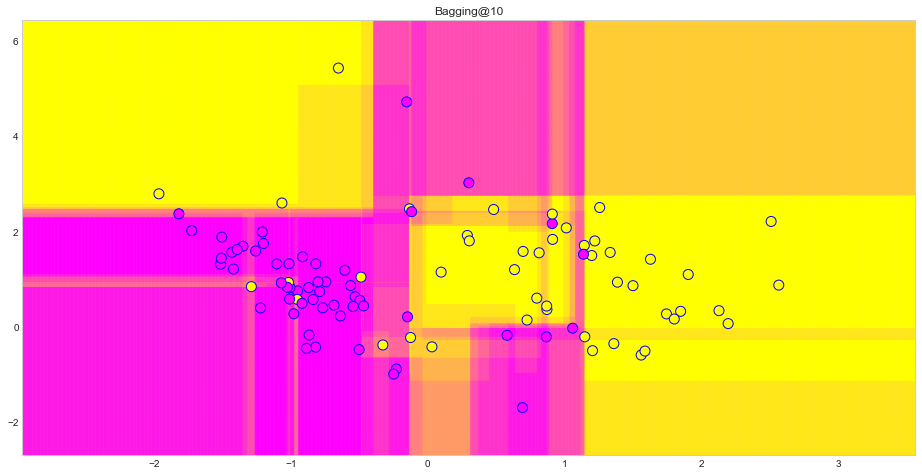

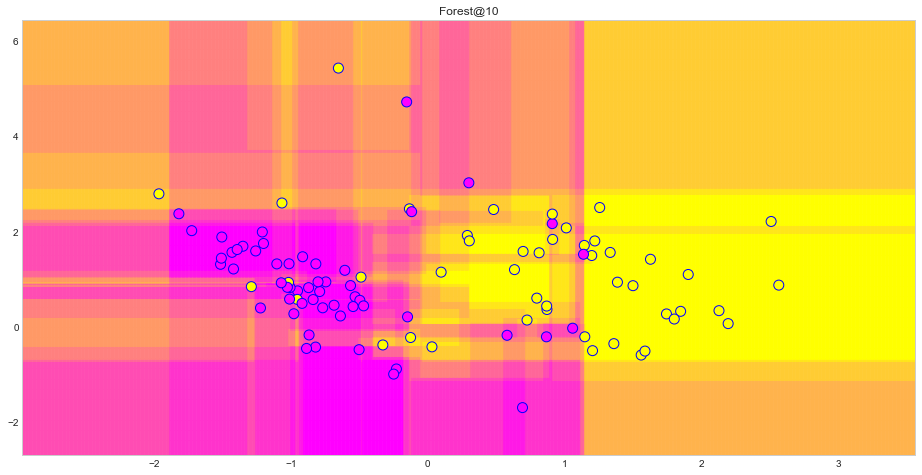

In [ ]:
for model_name, model in zip(('Tree', 'Bagging@10', 'Forest@10'), (tree, bagging, forest)):
    plot_model(X_toy, y_toy, model, proba=True, title=model_name)

### Самостоятельно:
* Добавить вычисление OOB-score
* Добавить оценку важности признаков (на выбор)
* Поэкспериментировать с параметрами одного дерева при построение случайного леса: максимальной глубина, минимальным значением критерия, ...
Для этого можно зафиксировать значение `n_base_models` и жадно подбирать значения других параметров